**Extracting Image Folders From Zip File (Downloaded from the drive)**

In [6]:
import zipfile
import os
zip_path = 'Celebrity Image Subsets-20251005T212736Z-1-001.zip'
extract_to = 'Celebrity_Image_Subsets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✓ Extracted to: {extract_to}")

✓ Extracted to: Celebrity_Image_Subsets


**Checking the extracted Folder**

In [6]:
import os
print(os.listdir('./Celebrity_Image_Subsets'))

['Celebrity Image Subsets']


**Importing Libraries**

In [1]:
import random
import cv2
import numpy as np
import albumentations as A
import yaml
import json
import os  # ← ADD THIS LINE
from tqdm import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image as IPImage, display

**Setting Directories & Configuration**

In [9]:
BASE_PATH = './Celebrity_Image_Subsets/Celebrity Image Subsets'
AUGMENTED_PATH_V2 = './augmented_celebrities_V2'
CONCATENATED_PATH_V2 = './concatenated_dataset_V2'
FINAL_AUGMENTED_PATH = './final_augmented_dataset'

NUM_CONCATENATED_IMAGES = 400  
CELEBS_PER_IMAGE = 25  
CONCAT_IMAGE_SIZE = 1280  

# STEP 1: Individual celebrity augmentation
AUGMENTATIONS_PER_IMAGE = 5  # ← KEEP THIS! For individual augmentation
TARGET_IMAGES_PER_CELEB = 100  # Target total images per celebrity folder

# STEP 3: Concatenated image augmentation  
AUGMENTATIONS_PER_CONCAT = 3  # ← ADD THIS! For concatenated image augmentation

# Training
EPOCHS = 35
BATCH_SIZE = 8
IMAGE_SIZE = 1280 

print("Configuration loaded - 3-step pipeline: Augment → Concat → Augment")

Configuration loaded - 3-step pipeline: Augment → Concat → Augment


**Creating the Augmentation Pipeline**

In [3]:
def create_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
        A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=15, val_shift_limit=15, p=0.3),
    ])

def create_augmentation_pipeline_with_bbox():  # ← ADD THIS WHOLE FUNCTION
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
        A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=15, val_shift_limit=15, p=0.3),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

print("Augmentation pipelines ready")

Augmentation pipelines ready


**Counting the number of images in each folder**

In [4]:

def count_images_by_folder(directory):
    """Count images per subfolder"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    folder_counts = {}
    total = 0
    
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            count = 0
            for file in os.listdir(folder_path):
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    count += 1
            folder_counts[folder] = count
            total += count
    
    return folder_counts, total

print("=" * 60)
print("IMAGE COUNT - BEFORE AUGMENTATION")
print("=" * 60)

before_by_folder, before_total = count_images_by_folder(BASE_PATH)

print(f"\nTotal celebrities: {len(before_by_folder)}")
print(f"Total images: {before_total}")
print(f"\nBreakdown by celebrity:")
for celebrity, count in sorted(before_by_folder.items()):
    print(f"  {celebrity}: {count} images")

IMAGE COUNT - BEFORE AUGMENTATION

Total celebrities: 45
Total images: 1493

Breakdown by celebrity:
  images__10046_: 23 images
  images__10173_: 30 images
  images__1158_: 24 images
  images__1499_: 30 images
  images__1852_: 30 images
  images__1964_: 23 images
  images__228_: 21 images
  images__2425_: 30 images
  images__2463_: 30 images
  images__2522_: 30 images
  images__2562_: 0 images
  images__2820_: 35 images
  images__2837_: 25 images
  images__2880_: 30 images
  images__3227_: 35 images
  images__3321_: 18 images
  images__3401_: 18 images
  images__3431_: 30 images
  images__3698_: 29 images
  images__3699_: 100 images
  images__3745_: 100 images
  images__3782_: 36 images
  images__4126_: 30 images
  images__4304_: 30 images
  images__447_: 30 images
  images__487_: 30 images
  images__5239_: 30 images
  images__6098_: 20 images
  images__619_: 15 images
  images__6568_: 31 images
  images__7282_: 30 images
  images__7904_: 29 images
  images__800_: 30 images
  images__

**Data Augmentation**

In [5]:
def augment_celebrity_folders(base_path, output_path, target_images=100):
    os.makedirs(output_path, exist_ok=True)
    augmentation_pipeline = create_augmentation_pipeline()
    
    celebrity_folders = [f for f in os.listdir(base_path) 
                        if os.path.isdir(os.path.join(base_path, f)) and f.startswith('images_')]
    
    celebrity_mapping = {}
    total_processed = 0
    
    for idx, folder in enumerate(tqdm(celebrity_folders, desc="Augmenting")):
        celebrity_mapping[idx] = folder
        folder_path = os.path.join(base_path, folder)
        output_folder = os.path.join(output_path, folder)
        os.makedirs(output_folder, exist_ok=True)
        
        image_files = [f for f in os.listdir(folder_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        num_original_images = len(image_files)
        
        if num_original_images == 0:
            print(f"  {folder} has no images, skipping...")
            continue
        
      
        total_per_image = max(1, target_images // num_original_images)
        augmentations_per_image = total_per_image - 1
        

        images_processed = 0
        
        for img_file in image_files:
            img_path = os.path.join(folder_path, img_file)
            
            try:
                image = cv2.imread(img_path)
                if image is None:
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                original_name = os.path.splitext(img_file)[0]
                
                # Save original
                cv2.imwrite(
                    os.path.join(output_folder, f"{original_name}_orig.jpg"),
                    cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                )
                images_processed += 1
                

                for aug_idx in range(augmentations_per_image):
                    augmented = augmentation_pipeline(image=image)['image']
                    cv2.imwrite(
                        os.path.join(output_folder, f"{original_name}_aug{aug_idx}.jpg"),
                        cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
                    )
                    images_processed += 1
                    
                    # Stop if we've reached the target
                    if images_processed >= target_images:
                        break
                
                if images_processed >= target_images:
                    break
                    
            except Exception as e:
                continue
        
        total_processed += 1
    
    with open(os.path.join(output_path, 'celebrity_mapping.json'), 'w') as f:
        json.dump(celebrity_mapping, f, indent=2)
    
    print(f"\nProcessed {total_processed} celebrity folders")
    print(f"Target: {target_images} images per folder")
    return celebrity_mapping


celebrity_mapping = augment_celebrity_folders(BASE_PATH, AUGMENTED_PATH_V2, target_images=100)

Augmenting:  22%|██▏       | 10/45 [00:04<00:15,  2.24it/s]

  images__2562_ has no images, skipping...


Augmenting: 100%|██████████| 45/45 [00:21<00:00,  2.05it/s]


Processed 44 celebrity folders
Target: 100 images per folder


**Images Count after Augmentation**

In [6]:
print("=" * 60)
print("IMAGE COUNT - AFTER AUGMENTATION")
print("=" * 60)

after_by_folder, after_total = count_images_by_folder(AUGMENTED_PATH_V2)

print(f"\nTotal celebrities: {len(after_by_folder)}")
print(f"Total images: {after_total}")
print(f"\nBreakdown by celebrity:")
for celebrity, count in sorted(after_by_folder.items()):
    original_count = before_by_folder.get(celebrity, 0)
    print(f"  {celebrity}: {count} images (was {original_count})")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Before: {before_total} images")
print(f"After: {after_total} images")
print(f"Increase: {after_total - before_total} images")
print(f"Multiplication: {after_total/before_total:.1f}x")
print(f"Average per celebrity: {after_total/len(after_by_folder):.0f} images")

IMAGE COUNT - AFTER AUGMENTATION

Total celebrities: 45
Total images: 3985

Breakdown by celebrity:
  images__10046_: 92 images (was 23)
  images__10173_: 90 images (was 30)
  images__1158_: 96 images (was 24)
  images__1499_: 90 images (was 30)
  images__1852_: 90 images (was 30)
  images__1964_: 92 images (was 23)
  images__228_: 84 images (was 21)
  images__2425_: 90 images (was 30)
  images__2463_: 90 images (was 30)
  images__2522_: 90 images (was 30)
  images__2562_: 0 images (was 0)
  images__2820_: 70 images (was 35)
  images__2837_: 100 images (was 25)
  images__2880_: 90 images (was 30)
  images__3227_: 70 images (was 35)
  images__3321_: 90 images (was 18)
  images__3401_: 90 images (was 18)
  images__3431_: 90 images (was 30)
  images__3698_: 87 images (was 29)
  images__3699_: 100 images (was 100)
  images__3745_: 100 images (was 100)
  images__3782_: 72 images (was 36)
  images__4126_: 90 images (was 30)
  images__4304_: 90 images (was 30)
  images__447_: 90 images (was 3

**Concatenating Images**

In [7]:
def create_concatenated_images(augmented_path, output_path, num_images=400, 
                               celebs_per_image=25, image_size=1280):
    """STEP 2: Create concatenated images (NO train/val split yet)"""
    
    concat_images_dir = os.path.join(output_path, 'concatenated_images')
    concat_labels_dir = os.path.join(output_path, 'concatenated_labels')
    
    os.makedirs(concat_images_dir, exist_ok=True)
    os.makedirs(concat_labels_dir, exist_ok=True)
    
    with open(os.path.join(augmented_path, 'celebrity_mapping.json'), 'r') as f:
        celebrity_mapping = json.load(f)
    
    celebrity_folders = list(celebrity_mapping.values())
    grid_size = int(np.sqrt(celebs_per_image))
    cell_size = image_size // grid_size
    
    print("=" * 60)
    print("STEP 2: CONCATENATION")
    print("=" * 60)
    print(f"Creating {num_images} concatenated images")
    print(f"Grid: {grid_size}x{grid_size}, Cell size: {cell_size}x{cell_size} pixels\n")
    
    for img_idx in tqdm(range(num_images), desc="Creating concatenated images"):
        canvas = np.zeros((image_size, image_size, 3), dtype=np.uint8)
        annotations = []
        
        selected_celebrities = random.choices(celebrity_folders, k=celebs_per_image)
        
        position_idx = 0
        for row in range(grid_size):
            for col in range(grid_size):
                if position_idx >= celebs_per_image:
                    break
                
                celeb_folder = selected_celebrities[position_idx]
                celeb_class_id = [k for k, v in celebrity_mapping.items() if v == celeb_folder][0]
                
                celeb_path = os.path.join(augmented_path, celeb_folder)
                celeb_images = [f for f in os.listdir(celeb_path) 
                               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                
                if celeb_images:
                    random_image = random.choice(celeb_images)
                    img_path = os.path.join(celeb_path, random_image)
                    
                    try:
                        celeb_img = cv2.imread(img_path)
                        if celeb_img is not None:
                            celeb_img = cv2.resize(celeb_img, (cell_size, cell_size))
                            
                            y_start = row * cell_size
                            x_start = col * cell_size
                            canvas[y_start:y_start+cell_size, x_start:x_start+cell_size] = celeb_img
                            
                            x_center = (x_start + cell_size / 2) / image_size
                            y_center = (y_start + cell_size / 2) / image_size
                            width = cell_size / image_size
                            height = cell_size / image_size
                            
                            annotations.append(f"{celeb_class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
                    except:
                        pass
                
                position_idx += 1
        
        # Save to single directory (NO split yet)
        img_filename = f"concat_{img_idx:04d}.jpg"
        cv2.imwrite(os.path.join(concat_images_dir, img_filename), canvas)
        
        label_filename = f"concat_{img_idx:04d}.txt"
        with open(os.path.join(concat_labels_dir, label_filename), 'w') as f:
            f.write('\n'.join(annotations))
    
    print(f"\n✓ Created {num_images} concatenated images")
    return celebrity_mapping

celebrity_mapping = create_concatenated_images(
    AUGMENTED_PATH_V2, CONCATENATED_PATH_V2, NUM_CONCATENATED_IMAGES, CELEBS_PER_IMAGE, CONCAT_IMAGE_SIZE
)

STEP 2: CONCATENATION
Creating 400 concatenated images
Grid: 5x5, Cell size: 256x256 pixels



Creating concatenated images: 100%|██████████| 400/400 [00:20<00:00, 19.19it/s]


✓ Created 400 concatenated images


In [8]:
def augment_and_split_concatenated(concat_path, output_path, augmentations_per_image=3):
    """STEP 3: Augment concatenated images, then split into train/val"""
    
    concat_images_dir = os.path.join(concat_path, 'concatenated_images')
    concat_labels_dir = os.path.join(concat_path, 'concatenated_labels')
    
    train_images_dir = os.path.join(output_path, 'images', 'train')
    train_labels_dir = os.path.join(output_path, 'labels', 'train')
    val_images_dir = os.path.join(output_path, 'images', 'val')
    val_labels_dir = os.path.join(output_path, 'labels', 'val')
    
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    
    augmentation_pipeline = create_augmentation_pipeline_with_bbox()
    
    concat_image_files = sorted([f for f in os.listdir(concat_images_dir) if f.endswith('.jpg')])
    
    print("=" * 60)
    print("STEP 3: AUGMENT CONCATENATED + SPLIT")
    print("=" * 60)
    print(f"Base concatenated images: {len(concat_image_files)}")
    print(f"Augmentations per image: {augmentations_per_image}")
    print(f"Total after augmentation: {len(concat_image_files) * (augmentations_per_image + 1)}\n")
    
    all_images = []
    all_labels = []
    
    for img_file in tqdm(concat_image_files, desc="Augmenting concatenated images"):
        base_name = os.path.splitext(img_file)[0]
        img_path = os.path.join(concat_images_dir, img_file)
        label_path = os.path.join(concat_labels_dir, f"{base_name}.txt")
        
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        bboxes = []
        class_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_labels.append(int(parts[0]))
                        bboxes.append([float(parts[1]), float(parts[2]), 
                                      float(parts[3]), float(parts[4])])
        
        # Save original
        all_images.append((f"{base_name}_orig.jpg", image.copy()))
        all_labels.append((f"{base_name}_orig.txt", class_labels.copy(), bboxes.copy()))
        
        # Create augmented versions
        for aug_idx in range(augmentations_per_image):
            try:
                augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['class_labels']
                
                all_images.append((f"{base_name}_aug{aug_idx}.jpg", aug_image.copy()))
                all_labels.append((f"{base_name}_aug{aug_idx}.txt", aug_labels, aug_bboxes))
            except:
                continue
    
    # Now split 80-20
    split_idx = int(len(all_images) * 0.8)
    
    print(f"\nSplitting into train/val...")
    print(f"Train: {split_idx} images (80%)")
    print(f"Val: {len(all_images) - split_idx} images (20%)\n")
    
    for i, ((img_name, img_data), (lbl_name, cls_labels, bbox_data)) in enumerate(zip(all_images, all_labels)):
        if i < split_idx:
            img_dir, lbl_dir = train_images_dir, train_labels_dir
        else:
            img_dir, lbl_dir = val_images_dir, val_labels_dir
        
        # Save image
        cv2.imwrite(os.path.join(img_dir, img_name), cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR))
        
        # Save label
        with open(os.path.join(lbl_dir, lbl_name), 'w') as f:
            for cls, bbox in zip(cls_labels, bbox_data):
                f.write(f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
    
    train_count = len([f for f in os.listdir(train_images_dir) if f.endswith('.jpg')])
    val_count = len([f for f in os.listdir(val_images_dir) if f.endswith('.jpg')])
    
    print(f"✓ Training: {train_count} images")
    print(f"✓ Validation: {val_count} images")
    print(f"✓ Ratio: {train_count/(train_count+val_count)*100:.1f}% / {val_count/(train_count+val_count)*100:.1f}%")

# Execute Step 3
augment_and_split_concatenated(CONCATENATED_PATH_V2, FINAL_AUGMENTED_PATH, AUGMENTATIONS_PER_CONCAT)

STEP 3: AUGMENT CONCATENATED + SPLIT
Base concatenated images: 400
Augmentations per image: 3
Total after augmentation: 1600



Augmenting concatenated images: 100%|██████████| 400/400 [00:27<00:00, 14.44it/s]



Splitting into train/val...
Train: 1280 images (80%)
Val: 320 images (20%)

✓ Training: 1280 images
✓ Validation: 320 images
✓ Ratio: 80.0% / 20.0%


**Model Building & Training**

In [10]:
config = {
    'path': os.path.abspath(FINAL_AUGMENTED_PATH),  # ← CHANGED
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(celebrity_mapping),
    'names': {int(k): v for k, v in celebrity_mapping.items()}
}
config_path = os.path.join(FINAL_AUGMENTED_PATH, 'data.yaml')  # ← CHANGED
# Rest stays the same
with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f" YOLO config created with {len(celebrity_mapping)} classes")

# Train
print("Starting training...")
model = YOLO('yolov8s.pt')
results = model.train(
    data=config_path,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    name='celebrity_detection',
    patience=30,
    save=True,
    device=0,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    augment=True,
    mosaic=0.5,
    mixup=0.0,
    copy_paste=0.0,
    scale=0.5,
    fliplr=0.5,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
)
print("\n✓ Training complete!")

 YOLO config created with 45 classes
Starting training...
New https://pypi.org/project/ultralytics/8.3.214 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.204 🚀 Python-3.10.16 torch-2.5.1 CUDA:0 (Tesla P100-PCIE-12GB, 12194MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./final_augmented_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosa

/opt/miniconda/envs/eai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Plotting labels to /courses/IE7615.202610/students/swamy.ar/OD-V2/runs/detect/celebrity_detection7/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to /courses/IE7615.202610/students/swamy.ar/OD-V2/runs/detect/celebrity_detection7
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/35      7.51G     0.3092      2.105     0.8989        183       1280: 100% ━━━━━━━━━━━━ 160/160 1.5it/s 1:500.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 2.4it/s 8.5s0.4s
                   all        320       7796      0.549      0.524      0.577      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/35      7.39G     0.1838     0.7528     0.8171     

In [11]:
import os

# Check the runs directory
runs_dir = 'runs/detect'
print("Available training runs:")
print("=" * 60)

if os.path.exists(runs_dir):
    runs = sorted([d for d in os.listdir(runs_dir) if d.startswith('celebrity_detection')])
    for run in runs:
        print(f"  {run}")
    
    # Get the latest run (highest number)
    latest_run = runs[-1] if runs else None
    
    if latest_run:
        print(f"\n✓ Latest run: {latest_run}")
        
        # Check for weights
        weights_dir = os.path.join(runs_dir, latest_run, 'weights')
        if os.path.exists(weights_dir):
            weights = os.listdir(weights_dir)
            print(f"\nWeights available:")
            for w in weights:
                weight_path = os.path.join(weights_dir, w)
                size_mb = os.path.getsize(weight_path) / (1024**2)
                print(f"  {w} ({size_mb:.2f} MB)")
            
            best_weight = os.path.join(weights_dir, 'best.pt')
            last_weight = os.path.join(weights_dir, 'last.pt')
            
            print(f"\n✓ Best weights: {best_weight}")
            print(f"✓ Last weights: {last_weight}")
            
            # Store the path for testing
            BEST_WEIGHTS = best_weight
            print(f"\n✓ Ready to test with: {BEST_WEIGHTS}")
else:
    print("Runs directory not found!")

Available training runs:
  celebrity_detection
  celebrity_detection2
  celebrity_detection3
  celebrity_detection4
  celebrity_detection5
  celebrity_detection6
  celebrity_detection7

✓ Latest run: celebrity_detection7

Weights available:
  best.pt (21.66 MB)
  last.pt (21.66 MB)

✓ Best weights: runs/detect/celebrity_detection7/weights/best.pt
✓ Last weights: runs/detect/celebrity_detection7/weights/last.pt

✓ Ready to test with: runs/detect/celebrity_detection7/weights/best.pt


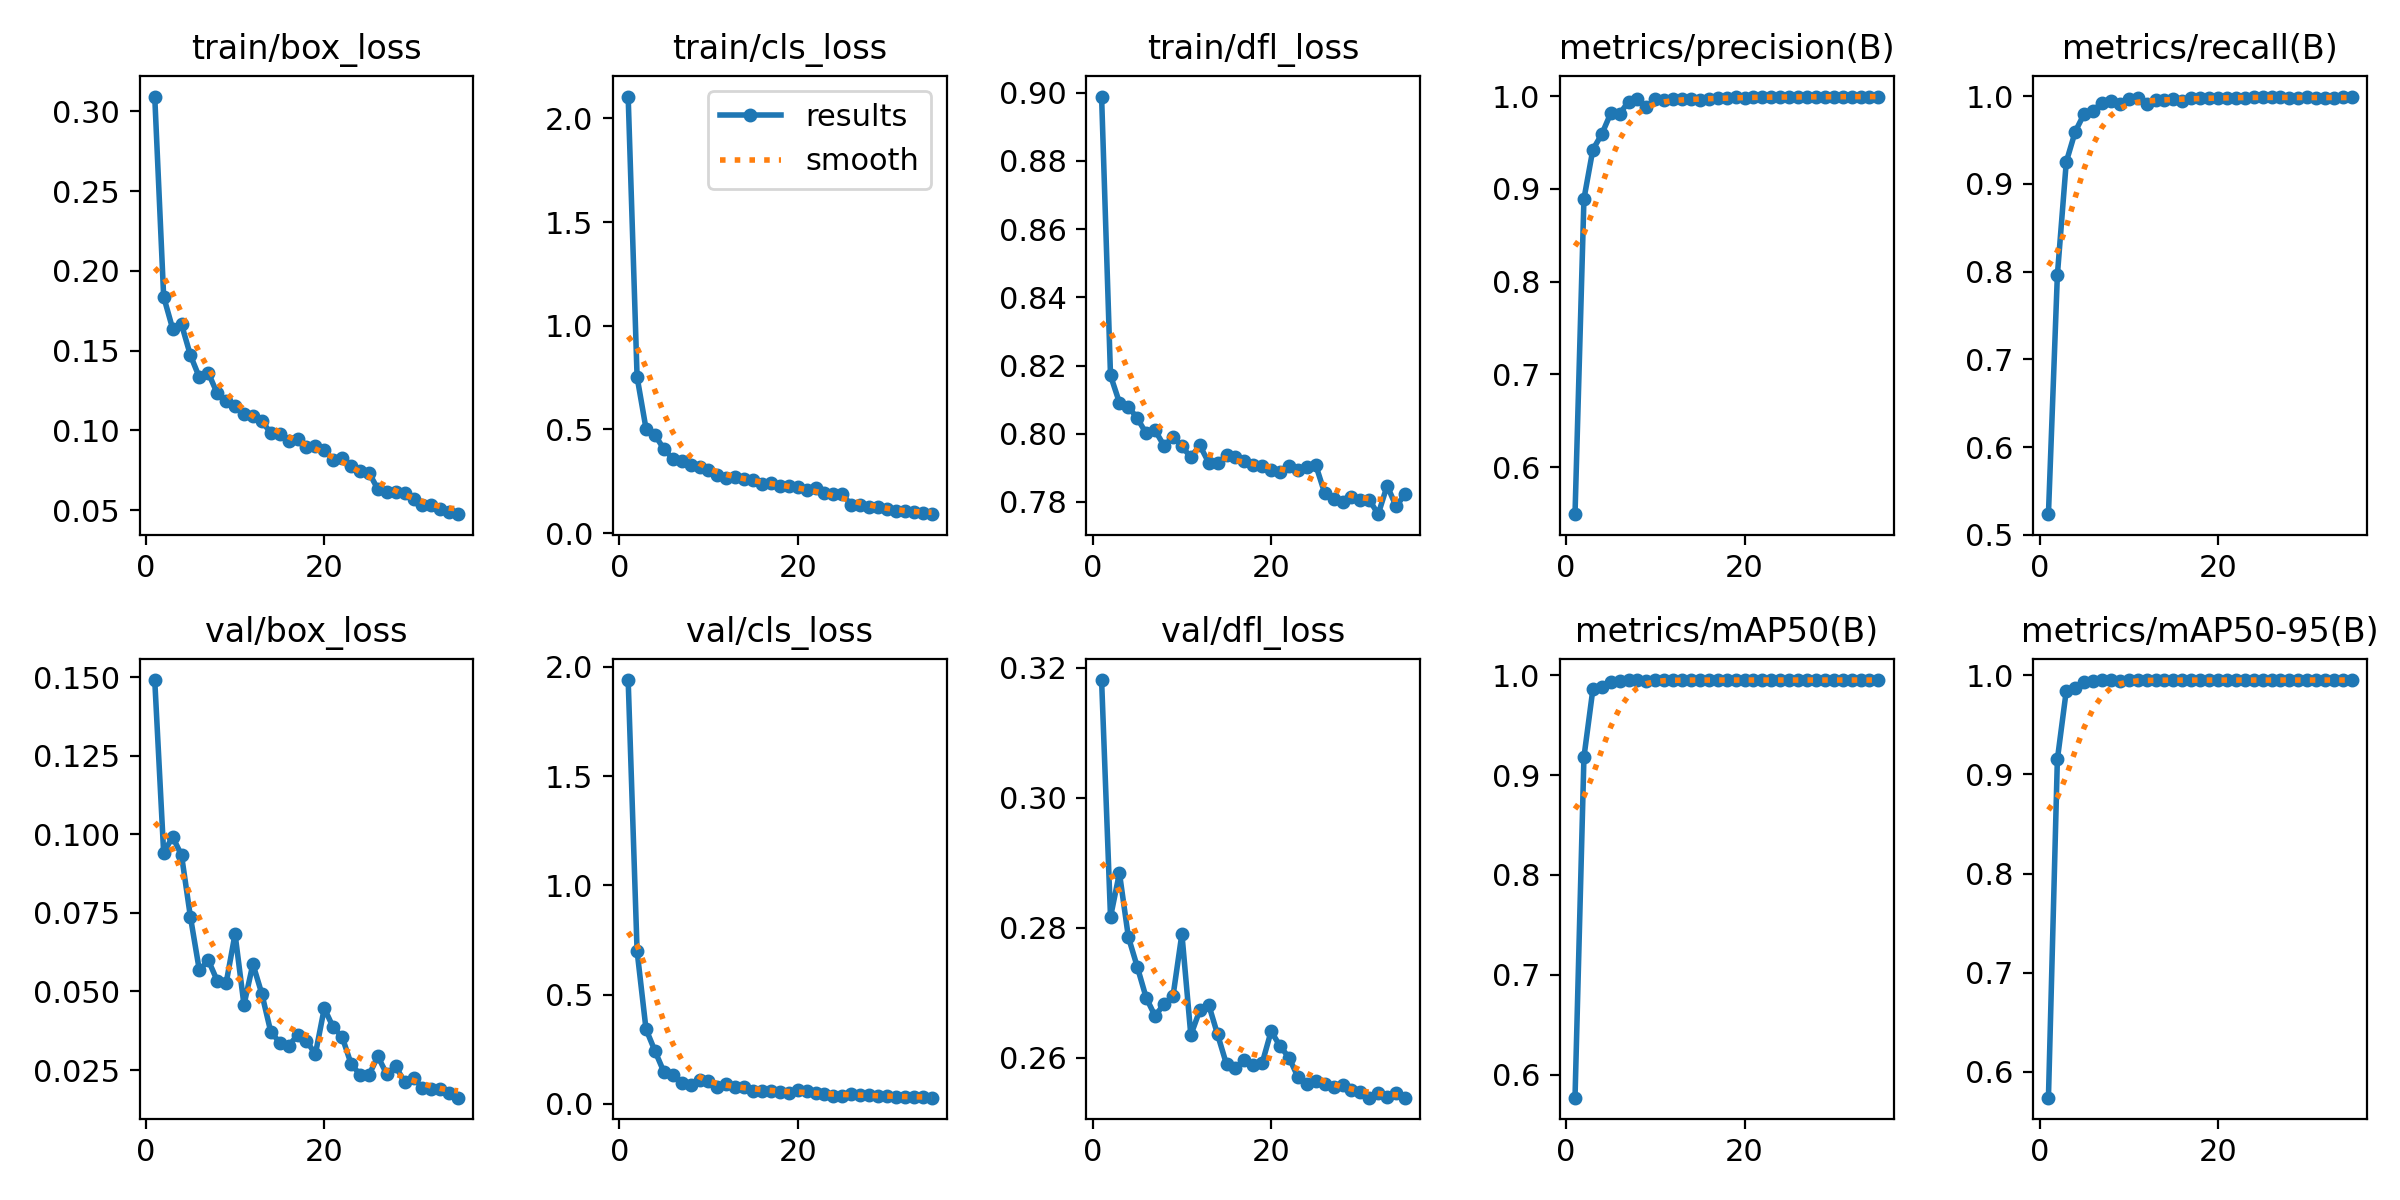

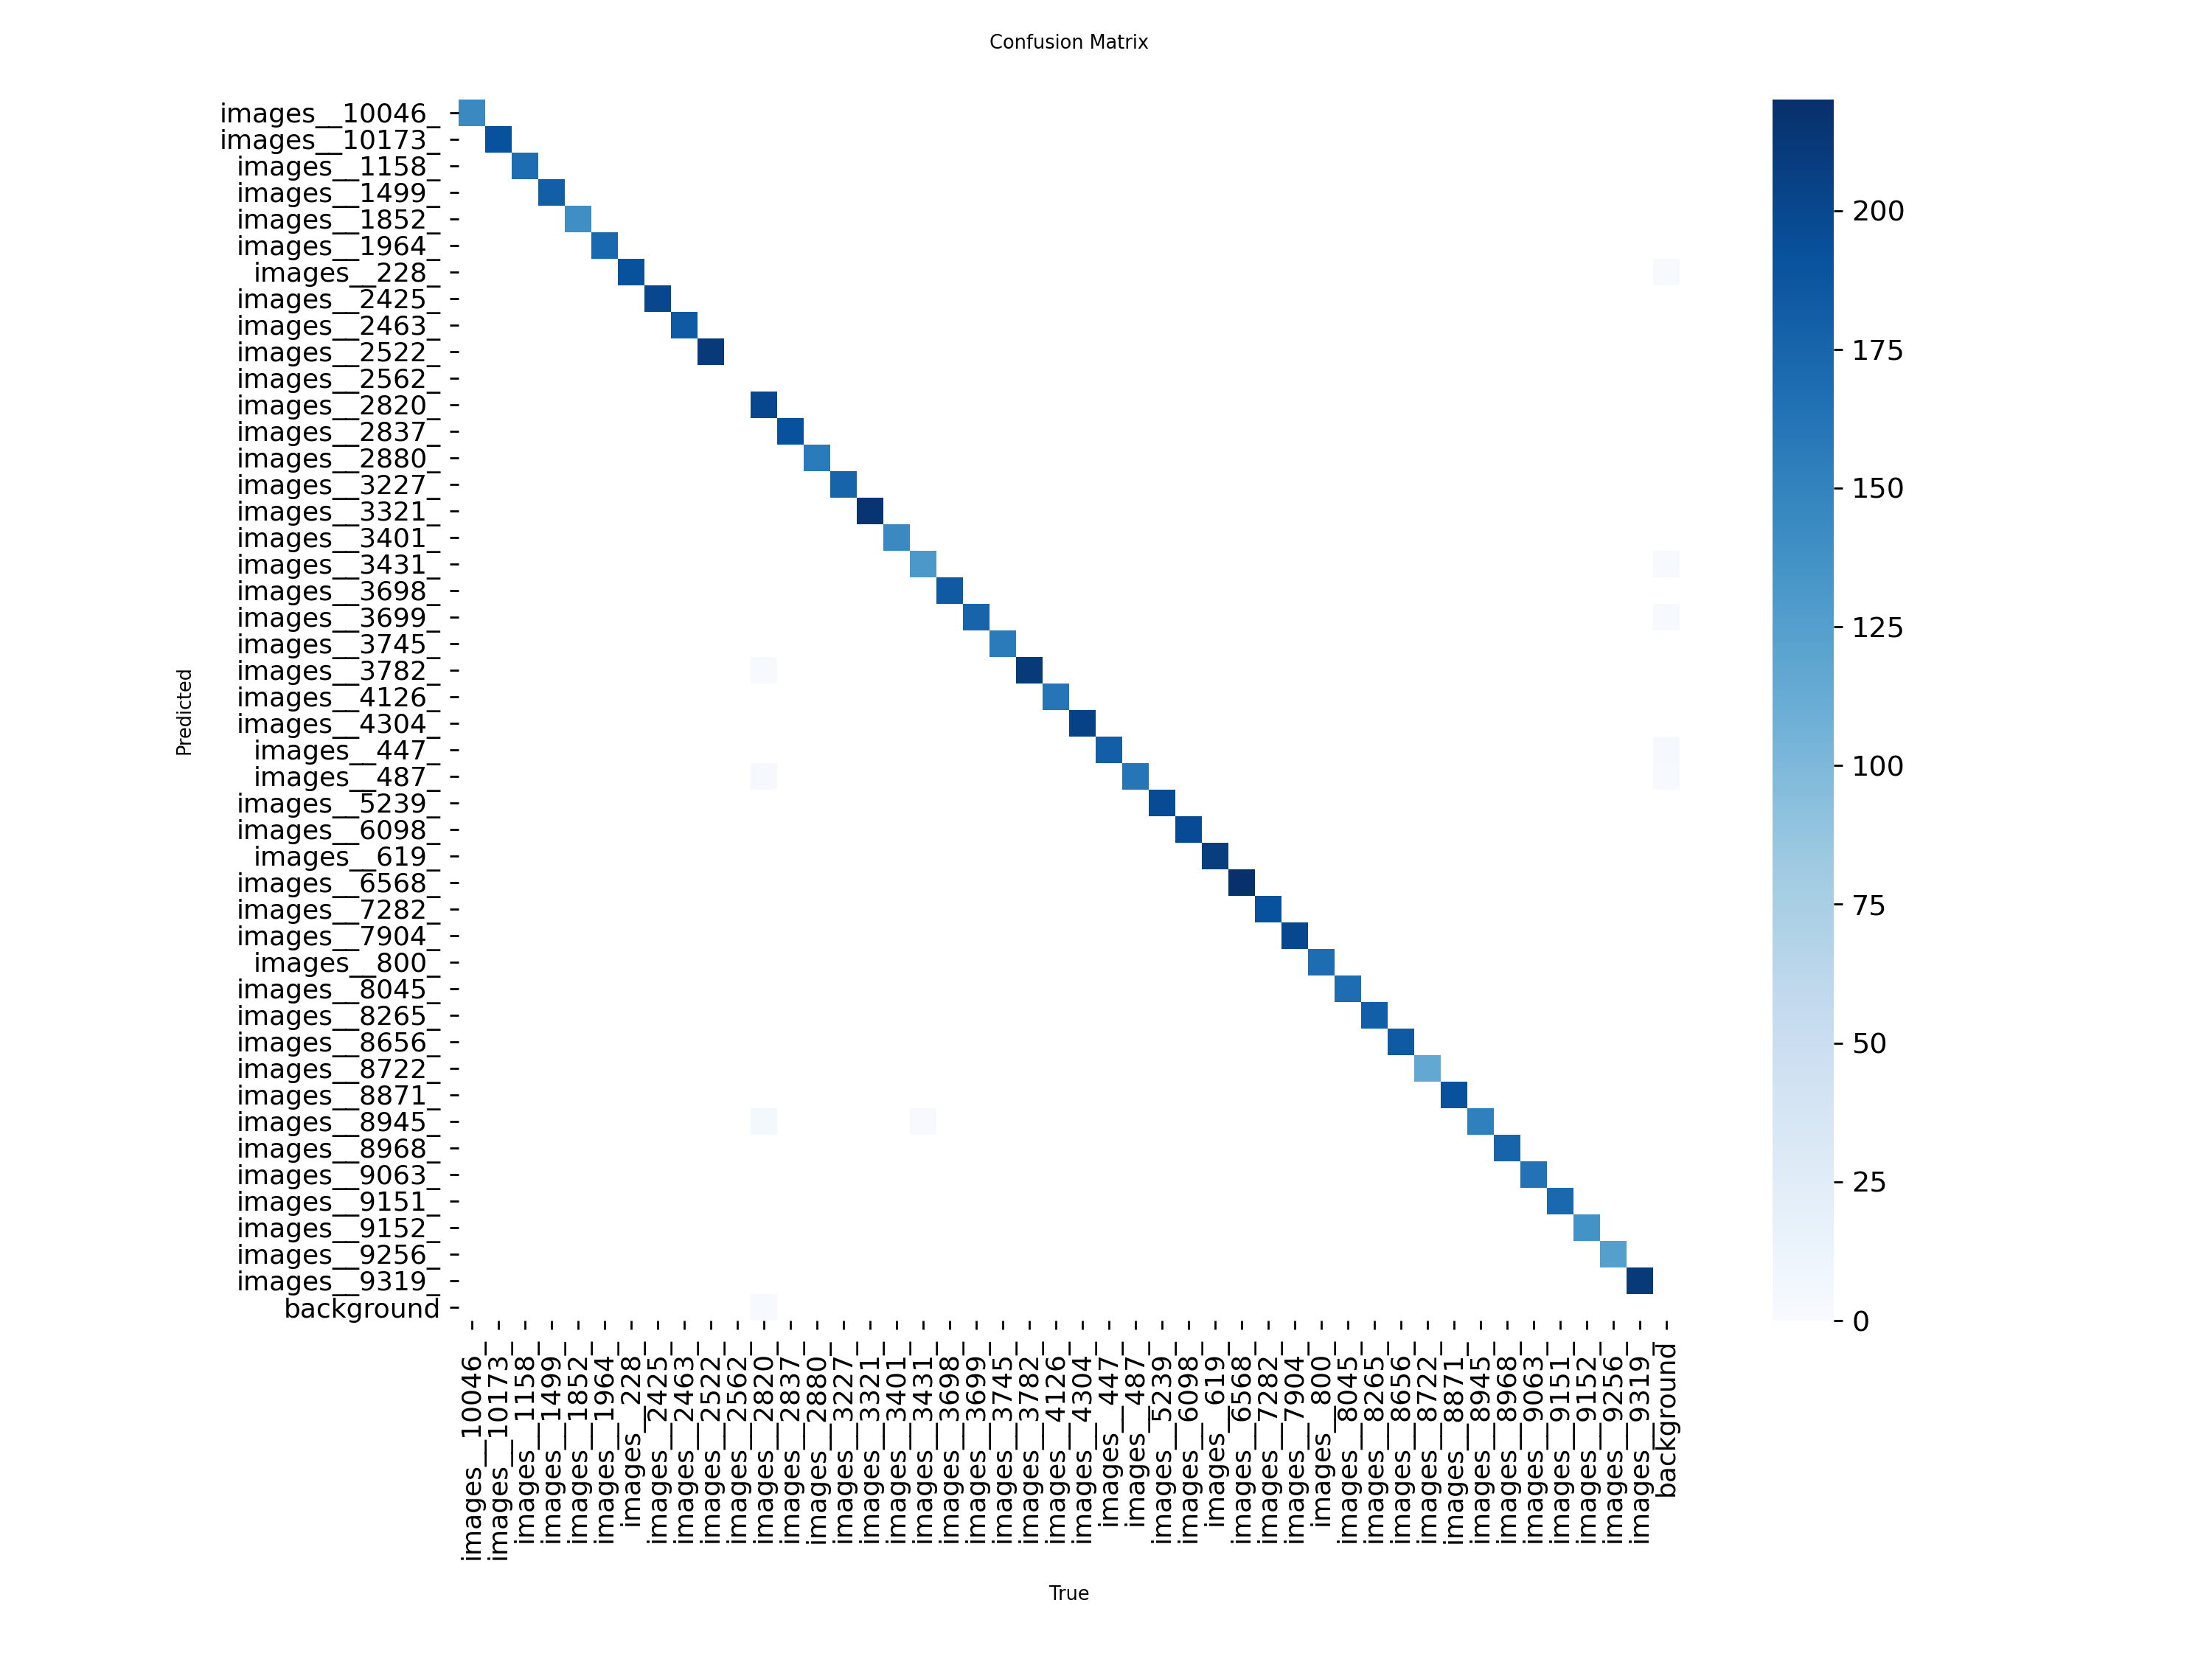

In [12]:

results_dir = 'runs/detect/celebrity_detection7'

if os.path.exists(os.path.join(results_dir, 'results.png')):
    display(IPImage(filename=os.path.join(results_dir, 'results.png')))
    
if os.path.exists(os.path.join(results_dir, 'confusion_matrix.png')):
    display(IPImage(filename=os.path.join(results_dir, 'confusion_matrix.png')))


**Testing on Validation Image**

In [15]:

model = YOLO('runs/detect/celebrity_detection7/weights/best.pt')

test_image = os.path.join(FINAL_AUGMENTED_PATH, 'images', 'val', 'concat_0321_aug2.jpg')


results = model(test_image, imgsz=1280, conf=0.15, iou=0.4)

for result in results:
    img = cv2.imread(test_image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(16, 16))
    ax.imshow(img_rgb)
    
    num_detections = len(result.boxes)
    print(f"Detections found: {num_detections}")
    
    if num_detections > 0:
        print("\nDetected celebrities:")
        print("=" * 80)
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            celebrity_name = celebrity_mapping[str(class_id)]
            
            # Print both ID and LOCATION
            print(f"\n{i+1}. Celebrity: {celebrity_name}")
            print(f"   Confidence: {confidence*100:.1f}%")
            print(f"   Location: ({x1:.0f}, {y1:.0f}) → ({x2:.0f}, {y2:.0f})")
            print(f"   Box size: {x2-x1:.0f}w × {y2-y1:.0f}h pixels")
            
            color = 'lime'
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            
            ax.text(x1, y1-10, f'{celebrity_name} {confidence:.2f}', 
                   color=color, fontsize=8, weight='bold',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        print("=" * 80)
    else:
        print("Still no detections - trying conf=0.05")
        results_low = model(test_image, imgsz=1280, conf=0.05, iou=0.3)
        print(f"With conf=0.05: {len(results_low[0].boxes)} detections")
    
    ax.axis('off')
    plt.title(f'Detection Results ({num_detections} detections)', fontsize=14)
    plt.tight_layout()
    plt.savefig('val_image_test.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\nResult saved to val_image_test.png")


image 1/1 /courses/IE7615.202610/students/swamy.ar/OD-V2/final_augmented_dataset/images/val/concat_0321_aug2.jpg: 1280x1280 1 images__1158_, 3 images__1852_s, 1 images__1964_, 1 images__228_, 1 images__3431_, 2 images__3698_s, 1 images__3699_, 1 images__3745_, 1 images__3782_, 1 images__4126_, 1 images__4304_, 1 images__6098_, 1 images__619_, 1 images__7282_, 1 images__7904_, 2 images__800_s, 1 images__8045_, 1 images__8968_, 1 images__9063_, 1 images__9256_, 1 images__9319_, 23.1ms
Speed: 4.0ms preprocess, 23.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)
Detections found: 25

Detected celebrities:

1. Celebrity: images__3699_
   Confidence: 99.7%
   Location: (512, 512) → (768, 768)
   Box size: 256w × 256h pixels

2. Celebrity: images__619_
   Confidence: 99.7%
   Location: (512, 768) → (768, 1024)
   Box size: 256w × 256h pixels

3. Celebrity: images__4304_
   Confidence: 99.7%
   Location: (256, 768) → (512, 1024)
   Box size: 256w × 256h pixels

4. Celebr

<Figure size 1600x1600 with 1 Axes>


Result saved to val_image_test.png


**Testing on NEW Concatenated Image (Unseen Data)**

In [16]:

def create_test_concatenated_image(augmented_path, output_path='./test_image', celebs_per_image=25, image_size=1280):
    """Create a single test image that was NOT in training or validation"""
    
    os.makedirs(output_path, exist_ok=True)
    
    with open(os.path.join(augmented_path, 'celebrity_mapping.json'), 'r') as f:
        celebrity_mapping = json.load(f)
    
    celebrity_folders = list(celebrity_mapping.values())
    grid_size = int(np.sqrt(celebs_per_image))
    cell_size = image_size // grid_size
    
    print(f"Creating test image with {celebs_per_image} celebrities")
    print(f"Grid: {grid_size}x{grid_size}, Cell size: {cell_size}x{cell_size} pixels\n")
    
    canvas = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    ground_truth_annotations = []
    
    selected_celebrities = random.choices(celebrity_folders, k=celebs_per_image)
    
    position_idx = 0
    celebrity_positions = []
    
    for row in range(grid_size):
        for col in range(grid_size):
            if position_idx >= celebs_per_image:
                break
            
            celeb_folder = selected_celebrities[position_idx]
            celeb_class_id = [k for k, v in celebrity_mapping.items() if v == celeb_folder][0]
            
            celeb_path = os.path.join(augmented_path, celeb_folder)
            celeb_images = [f for f in os.listdir(celeb_path) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            if celeb_images:
                random_image = random.choice(celeb_images)
                img_path = os.path.join(celeb_path, random_image)
                
                try:
                    celeb_img = cv2.imread(img_path)
                    if celeb_img is not None:
                        celeb_img = cv2.resize(celeb_img, (cell_size, cell_size))
                        
                        y_start = row * cell_size
                        x_start = col * cell_size
                        canvas[y_start:y_start+cell_size, x_start:x_start+cell_size] = celeb_img
                        
                        ground_truth_annotations.append({
                            'class_id': celeb_class_id,
                            'celebrity': celeb_folder,
                            'bbox_pixels': [x_start, y_start, x_start+cell_size, y_start+cell_size],
                            'grid_position': f'Row {row+1}, Col {col+1}'
                        })
                        
                        celebrity_positions.append(f"{celeb_folder} at ({row+1}, {col+1})")
                except:
                    pass
            
            position_idx += 1
    
    test_img_path = os.path.join(output_path, 'test_concat.jpg')
    cv2.imwrite(test_img_path, canvas)
    
    ground_truth_path = os.path.join(output_path, 'ground_truth.json')
    with open(ground_truth_path, 'w') as f:
        json.dump(ground_truth_annotations, f, indent=2)
    
    print(f" Test image created: {test_img_path}")
    print(f" Ground truth saved: {ground_truth_path}")
    print(f" Total celebrities: {len(ground_truth_annotations)}\n")
    
    img_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 14))
    plt.imshow(img_rgb)
    plt.title(f'Test Image ({len(ground_truth_annotations)} Celebrities)', fontsize=14)
    plt.axis('off')
    plt.show()
    
    print("First 10 celebrities:")
    for i, pos in enumerate(celebrity_positions[:10]):
        print(f"  {i+1}. {pos}")
    
    return test_img_path, ground_truth_annotations, celebrity_mapping

# Create test image
test_img_path, ground_truth, celeb_map = create_test_concatenated_image(
    AUGMENTED_PATH_V2, 
    celebs_per_image=CELEBS_PER_IMAGE, 
    image_size=CONCAT_IMAGE_SIZE
)

# Test the model on concatenated image
print("\n" + "="*80)
print("TESTING MODEL ON CONCATENATED IMAGE")
print("="*80)

model = YOLO('runs/detect/celebrity_detection7/weights/best.pt')
results = model(test_img_path, imgsz=1280, conf=0.15, iou=0.4)

for result in results:
    img = cv2.imread(test_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(16, 16))
    ax.imshow(img_rgb)
    
    num_detections = len(result.boxes)
    print(f"\nDetections found: {num_detections}")
    print(f"Ground truth: {len(ground_truth)} celebrities\n")
    
    if num_detections > 0:
        print("Detected celebrities:")
        print("="*80)
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            celebrity_name = celeb_map[str(class_id)]
            
            print(f"\n{i+1}. Celebrity: {celebrity_name}")
            print(f"   Confidence: {confidence*100:.1f}%")
            print(f"   Location: ({x1:.0f}, {y1:.0f}) → ({x2:.0f}, {y2:.0f})")
            print(f"   Box size: {x2-x1:.0f}w × {y2-y1:.0f}h pixels")
            
            color = 'lime'
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            
            ax.text(x1, y1-10, f'{celebrity_name} {confidence:.2f}', 
                   color=color, fontsize=8, weight='bold',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        print("="*80)
    
    ax.axis('off')
    plt.title(f'Concatenated Test Results: {num_detections}/{len(ground_truth)} detected', fontsize=14)
    plt.tight_layout()
    plt.savefig('unseen_v1.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n✓ Results saved to unseen_v1.png")

Creating test image with 25 celebrities
Grid: 5x5, Cell size: 256x256 pixels

 Test image created: ./test_image/test_concat.jpg
 Ground truth saved: ./test_image/ground_truth.json
 Total celebrities: 25



<Figure size 1400x1400 with 1 Axes>

First 10 celebrities:
  1. images__9063_ at (1, 1)
  2. images__2522_ at (1, 2)
  3. images__228_ at (1, 3)
  4. images__228_ at (1, 4)
  5. images__1852_ at (1, 5)
  6. images__8656_ at (2, 1)
  7. images__9319_ at (2, 2)
  8. images__4304_ at (2, 3)
  9. images__7904_ at (2, 4)
  10. images__6098_ at (2, 5)

TESTING MODEL ON CONCATENATED IMAGE

image 1/1 /courses/IE7615.202610/students/swamy.ar/OD-V2/test_image/test_concat.jpg: 1280x1280 1 images__1158_, 1 images__1499_, 2 images__1852_s, 3 images__228_s, 2 images__2522_s, 2 images__3227_s, 1 images__3321_, 1 images__3699_, 2 images__4304_s, 1 images__447_, 1 images__487_, 1 images__6098_, 1 images__619_, 1 images__7904_, 1 images__8656_, 1 images__8945_, 1 images__9063_, 1 images__9151_, 1 images__9319_, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

Detections found: 25
Ground truth: 25 celebrities

Detected celebrities:

1. Celebrity: images__487_
   Confidence: 99.7%
   

<Figure size 1600x1600 with 1 Axes>


✓ Results saved to unseen_v1.png


**Thus, the model is performing well with both the validation set and even with unseen data**